In [1]:
# sklearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# sklearn Utils
from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.model_selection import train_test_split

import numpy as np
from numpy.random import default_rng
import random

np.random.seed(42)

from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerTuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from celluloid import Camera
except ModuleNotFoundError:
    %pip install -qq celluloid
    from celluloid import Camera

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils import active_learn_utils as alu

try:
    import modAL
except ModuleNotFoundError:
    %pip install -qq modAL
    import modAL


from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import margin_sampling
from modAL.disagreement import max_std_sampling


from modAL.models import ActiveLearner
from modAL.utils.data import modALinput
from modAL.models import Committee


from typing import Callable
from typing import Tuple
from typing import Optional
import warnings
from typing import List

from IPython.display import HTML
from functools import reduce
import operator

2022-07-28 09:02:29.305916: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-28 09:02:29.402707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 09:02:29.402737: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Default RC parms for grid and line plot
p = plt.rcParams

# Grid Setting
p["grid.color"] = "#999999"
p["grid.linestyle"] = "--"

# Markersize setting for scatter
if pml.is_latexify_enabled():
    p["lines.markersize"] = 3
    p["lines.markeredgewidth"] = 1
    p["lines.linewidth"] = 1.5
    p["grid.linewidth"] = 0.5
else:
    p["lines.markersize"] = 5
    p["lines.markeredgewidth"] = 1.5
    p["lines.linewidth"] = 2

## Decision Contour Plots

In [3]:
def plot_countor(
    prob: np.ndarray,
    xx: np.ndarray,
    yy: np.ndarray,
    cmap: str,
    ax: mpl.axes.Axes,
    fig: mpl.figure.Figure,
):
    """
    Plot countors for the given meshgrid and probabilities

    Args:
    ----------
    prob :
        Probabilities to be displayed over the meshgrid

    xx :
        Meshgrid x-coords

    yy :
        Meshgrid y-coords

    cmap :
        Color for the countor

    ax :
        Matplotlib axes

    fig :
        Matplotlib figure

    Returns:
    ----------
    ax :
        Matplotlib axes

    fig :
        Matplotlib figure

    """

    # Mask probabilities low probabilities for a given class
    # since contours overlap, the colors look saturated
    prob = np.ma.masked_where(prob < 0.20, prob)

    # Add a countor lines and countor plot
    ax.contourf(
        xx,
        yy,
        prob,
        cmap=cmap,
        alpha=0.3,
        levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    )

    ax.contour(
        xx,
        yy,
        prob,
        cmap=cmap,
        alpha=0.4,
        linewidths=2,
        levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    )

    return fig, ax

In [4]:
def final_decision_countor(
    key: str,
    i: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_train_qry: np.ndarray,
    y_train_qry: np.ndarray,
    probs: np.ndarray,
    xx: np.ndarray,
    yy: np.ndarray,
    cmaps: list,
    X_pool: np.ndarray,
    y_pool: np.ndarray,
    save_name: str,
) -> None:

    """
    At any given iteration save the countour plots

    Args:
    ----------
    key :
        Query Stratergy Name

    i:
        The current Iteration

    X_train_qry :
       Train+queried sample features

    y_train_qry :
        Train+queried sample labels

    X_train :
        Train data features

    y_train :
        Train data labels

    probs:
        Probabilities for surface plot

    xx :
        Meshgrid x-coords

    yy :
        Meshgrid y-coords

    cmap :
        Color for the countor

    X_pool :
        Features pool data

    y_pool :
        Labels pool data

    save_name:
        Fig name to save

    Returns:
    ----------
    None
    """

    # Create a figure
    pml.latexify(width_scale_factor=3)
    fig = plt.figure()
    ax = plt.gca()
    ax.grid(False)

    for prob_idx in range(probs.shape[1]):
        plot_countor(probs[:, prob_idx].reshape(xx.shape), xx, yy, cmaps[prob_idx], ax, fig)

    # Scatter plot of Pool data
    pool_pts = ax.scatter(X_pool[:, 0], X_pool[:, 1], c="darkgrey", label="Pool Points", alpha=0.75)

    # Scatter Plots for train data
    class_0_train = ax.scatter(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], c="blue", zorder=2)
    class_1_train = ax.scatter(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], c="purple", zorder=2)
    class_2_train = ax.scatter(X_train[:, 0][y_train == 2], X_train[:, 1][y_train == 2], c="green", zorder=2)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel("Feature 1")

    # Get Queried Points excluding the train data
    X_only_qry = X_train_qry[-i:]
    y_only_qry = y_train_qry[-i:]

    # Setup legends and display for when queried points are shown
    if i != 0:
        class_0 = ax.scatter(
            X_only_qry[:, 0][y_only_qry == 0],
            X_only_qry[:, 1][y_only_qry == 0],
            linewidths=0.75,
            s=15,
            edgecolor="black",
            c="blue",
            zorder=3,
        )
        class_1 = ax.scatter(
            X_only_qry[:, 0][y_only_qry == 1],
            X_only_qry[:, 1][y_only_qry == 1],
            linewidths=0.75,
            s=15,
            edgecolor="black",
            c="purple",
            zorder=3,
        )
        class_2 = ax.scatter(
            X_only_qry[:, 0][y_only_qry == 2],
            X_only_qry[:, 1][y_only_qry == 2],
            linewidths=0.75,
            s=15,
            edgecolor="black",
            c="green",
            zorder=3,
        )
        ax.legend(
            [
                (class_0, class_1, class_2),
                (class_0_train, class_1_train, class_2_train),
                (pool_pts),
            ],
            ["Queried Data", "Train Data", "Pool Data"],
            loc="upper left",
            fontsize=5,
            framealpha=0.7,
            handler_map={tuple: HandlerTuple(ndivide=None)},
        )
    # Setup legends for only when train data is shown
    else:
        ax.set_ylabel("Feature 2")
        ax.legend(
            [(class_0_train, class_1_train, class_2_train), (pool_pts)],
            ["Train Data", "Pool Data"],
            loc="upper left",
            fontsize=5,
            framealpha=0.7,
            handler_map={tuple: HandlerTuple(ndivide=None)},
        )

    pml.savefig(save_name)

In [5]:
def final_decision_bound(
    key: str,
    i: int,
    X_all: np.ndarray,
    y_all: np.ndarray,
    X_train: np.ndarray,
    y_train: np.ndarray,
    predictions,
    query_x0,
    query_x1,
    xx: np.ndarray,
    yy: np.ndarray,
    cmap: list,
    save_name: str,
) -> None:
    """
    At any given iteration save the decision boundary plots

    Args:
    ----------
    key :
        Query Stratergy Name

    i:
        The current Iteration

    X_all :
       Train+pool sample features

    y_all :
        Train+pool sample labels

    X_train :
        Train data features

    y_train :
        Train data labels

    predictions:
        Predictions

    xx :
        Meshgrid x-coords

    yy :
        Meshgrid y-coords

    cmap :
        Color for the countor

    save_name:
        Fig name to save

    Returns:
    ----------
    None
    """

    # Setup Figure
    pml.latexify(width_scale_factor=2)
    fig = plt.figure()
    ax = plt.gca()
    ax.grid(False)

    # Create a Countorrf plot
    ax.contourf(xx, yy, predictions, cmap=cmap)

    # Display all data
    class_0 = ax.scatter(X_all[:, 0][y_all == 0], X_all[:, 1][y_all == 0], c="b")
    class_1 = ax.scatter(X_all[:, 0][y_all == 1], X_all[:, 1][y_all == 1], c="y")
    class_2 = ax.scatter(X_all[:, 0][y_all == 2], X_all[:, 1][y_all == 2], c="g")

    # Highlight train data
    train_pts = ax.scatter(
        X_train[:, 0],
        X_train[:, 1],
        c="red",
        zorder=2,
        s=25,
        edgecolor="black",
        label="Train Data",
    )

    # Setup legends and display for when queried points are shown
    if i != 0:
        query_pts = ax.scatter(
            query_x0,
            query_x1,
            c="darkorange",
            marker="o",
            zorder=2,
            s=25,
            edgecolor="black",
            label="Queried Data",
        )
        ax.legend(
            [(class_0, class_1, class_2), train_pts, query_pts],
            ["Pool Data", "Train Data", "Queried Data"],
            loc="lower left",
            fontsize=6,
            framealpha=0.4,
            handler_map={tuple: HandlerTuple(ndivide=None)},
        )
    # Setup legends for only when train data is shown
    else:
        ax.legend(
            [(class_0, class_1, class_2), train_pts],
            ["Pool Data", "Train Data"],
            loc="lower left",
            fontsize=6,
            framealpha=0.4,
            handler_map={tuple: HandlerTuple(ndivide=None)},
        )

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

    pml.savefig(save_name)

In [6]:
def animate_classification(
    sampling_dict_class: dict,
    plot_list: list,
    grid_row: int = 3,
    grid_col: int = 3,
    n_queries=100,
):
    """
    Make animations for classification

    Args:
    ----------
    sampling_dict_class :
        Dictionary to store data for all different uncertanity techniques

    plot_list:
        Choose the plots you want to see

    grid_row:
        # of rows in plot

    grid_col:
        # of columns in plot

    n_queries:
        # of queries for uncertanity sampling

    Returns:
    ----------
    animation:
        An animation of all the plots

    """

    # Intialize Plots
    if len(plot_list) == 3:
        fig, ax = plt.subplots(grid_row, grid_col, figsize=(20, 15))
    else:
        fig, ax = plt.subplots(grid_row, grid_col, figsize=(16, 10))

    camera = Camera(fig)

    # Generate relevant data
    (
        x_min,
        x_max,
        y_min,
        y_max,
        xx,
        yy,
        X_train,
        X_pool,
        y_train,
        y_pool,
        X_test,
        y_test,
    ) = alu.make_data_class()

    # Create all data, needed for plotting later
    X_all = np.append(X_train, X_pool, axis=0)
    y_all = np.append(y_train, y_pool, axis=0)

    # Iterate over each sampling technique and store its results
    # in correspoding dictionary for later
    for uncert_key, uncert_val in sampling_dict_class.items():
        (
            uncert_val["queries_np_X"],
            uncert_val["queries_np_y"],
            uncert_val["score"],
            uncert_val["X_pool"],
            uncert_val["y_pool"],
        ) = alu.process_uncertainty_result(
            uncert_val["model"],
            uncert_val["query_strat"],
            "Classification",
            uncert_key,
            n_queries=n_queries,
            X_pool=X_pool,
            y_pool=y_pool,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
        )

    # Loop over each iteration in each sampling stratergy
    for i in range(n_queries + 1):

        # Go over each sampling stratergy
        for col, (key, value) in enumerate(sampling_dict_class.items()):

            # If initial iteration only consider the train points else consider queried points+train points
            if i == 0:
                X_train_qry = X_train
                y_train_qry = y_train
            else:
                X_train_qry = np.append(X_train, value["queries_np_X"][:i, :], axis=0)
                y_train_qry = np.append(y_train, value["queries_np_y"][:i])

            # Fit the model
            model_qry = clone(uncert_val["model"]).fit(X_train_qry, y_train_qry)

            # Predict probabilities on meshgrid to display countors
            probs = model_qry.predict_proba(np.c_[xx.ravel(), yy.ravel()])

            # Make predictions on meshgrid to display decision bounds
            predictions = model_qry.predict(np.c_[xx.ravel(), yy.ravel()])
            predictions = predictions.reshape(xx.shape)

            # For each sampling type plot a column of 3 plots
            for row, graph_type in enumerate(plot_list):

                if graph_type == "decision_bound":

                    ax[row][col].grid(False)

                    # Make a custom cmap
                    custom_cmap = ListedColormap(["#9898ff", "#fafab0", "#a0faa0"])

                    # Plot contour
                    ax[row][col].contourf(xx, yy, predictions, cmap=custom_cmap)

                    # Plot all the data indicating different classes
                    ax[row][col].scatter(
                        X_all[:, 0],
                        X_all[:, 1],
                        c=np.array(["b", "y", "g"])[y_all],
                        s=30,
                    )

                    # Highlight train data
                    ax[row][col].scatter(
                        X_train[:, 0],
                        X_train[:, 1],
                        c=np.array(["b", "y", "g"])[y_train],
                        s=35,
                        edgecolor="black",
                    )

                    # Select all the points queried till now
                    qry_pt = value["queries_np_X"][:i, :]

                    # Only display queried points when query iteration>0
                    if i != 0:
                        ax[row][col].scatter(
                            qry_pt[:, 0],
                            qry_pt[:, 1],
                            c="darkorange",
                            marker="o",
                            s=35,
                            edgecolor="black",
                        )

                    # Graph Options
                    ax[row][col].set_xlim(xx.min(), xx.max())
                    ax[row][col].set_ylim(yy.min(), yy.max())
                    ax[row][col].set_xticks(())
                    ax[row][col].set_yticks(())

                    # Take a snap of graphs at any given iteration
                    if i in [] and pml.is_latexify_enabled() and value["save_dec"] and value["save_fig"]:
                        print(
                            f"Plotting Decision Boundary, the Current Stratergy is {key} and accuracy at iteration:{i} is {value['score'][i]}"
                        )
                        final_decision_bound(
                            key,
                            i,
                            X_all,
                            y_all,
                            X_train,
                            y_train,
                            predictions,
                            qry_pt[:, 0],
                            qry_pt[:, 1],
                            xx,
                            yy,
                            custom_cmap,
                            f"{value['save_dec']}_db_iter_{i}",
                        )

                elif graph_type == "decision_countour":

                    # Decision Boundary Plot using countours

                    # Color maps for countors
                    cmaps = ["Blues", "Purples", "Greens"]

                    # Plot contours for each class
                    for prob_idx in range(probs.shape[1]):
                        plot_countor(
                            probs[:, prob_idx].reshape(xx.shape),
                            xx,
                            yy,
                            cmaps[prob_idx],
                            ax[row][col],
                            fig,
                        )

                    # Plot all pool data
                    ax[row][col].scatter(
                        value["X_pool"][0][:, 0],
                        value["X_pool"][0][:, 1],
                        c="darkgrey",
                        alpha=0.3,
                    )

                    # Plot all queried data
                    ax[row][col].scatter(
                        X_train_qry[:, 0][-i:],
                        X_train_qry[:, 1][-i:],
                        c=np.array(["blue", "purple", "green"])[y_train_qry[-i:]],
                        edgecolor="black",
                        zorder=3,
                    )

                    # Plot train data
                    ax[row][col].scatter(
                        X_train[:, 0],
                        X_train[:, 1],
                        c=np.array(["blue", "purple", "green"])[y_train],
                        zorder=3,
                    )

                    # Plot the next queried point
                    if i != 0:
                        ax[row][col].scatter(
                            X_train_qry[:, 0][-1],
                            X_train_qry[:, 1][-1],
                            c=np.array(["blue", "purple", "green"])[y_train_qry][-1],
                            s=100,
                            edgecolor="black",
                            zorder=4,
                        )

                    # Graph options
                    ax[row][col].set_xlim(xx.min(), xx.max())
                    ax[row][col].set_ylim(yy.min(), yy.max())
                    ax[row][col].set_xticks(())
                    ax[row][col].set_yticks(())
                    ax[row][col].set_title(key, color=value["color_scheme"])

                    # Save at an any iteration
                    if (
                        i in value["save_iter_dc"]
                        and pml.is_latexify_enabled()
                        and value["save_dec"]
                        and value["save_fig"]
                    ):
                        print(
                            f"Plotting Decision Contour, the Current Stratergy is {key} and accuracy at iteration:{i} is {value['score'][i]}"
                        )
                        final_decision_countor(
                            key,
                            i,
                            X_train,
                            y_train,
                            X_train_qry,
                            y_train_qry,
                            probs,
                            xx,
                            yy,
                            cmaps,
                            value["X_pool"][0],
                            value["y_pool"][0],
                            f"{value['save_dec']}_dc_iter_{i}",
                        )

                elif graph_type == "accuracy_line":

                    # Accuracy Plot
                    ax[row][col].grid(True)

                    # Plot accuracy curves
                    if i == 0:
                        ax[row][col].scatter([i], value["score"][i], color=value["color_scheme"])
                    else:
                        ax[row][col].plot(
                            [itr for itr in range(i + 1)],
                            value["score"][: i + 1],
                            color=value["color_scheme"],
                        )
                        ax[row][col].set_xticks([i for i in range(0, i + 1, 2)])

                    ax[row][col].set_xlabel("Number of Iterations")

                    if col == 0:
                        ax[row][col].set_ylabel("Classification Accuracy")

        plt.subplots_adjust(hspace=0.2)

        camera.snap()

    animation = camera.animate(interval=500, blit=True)
    return animation

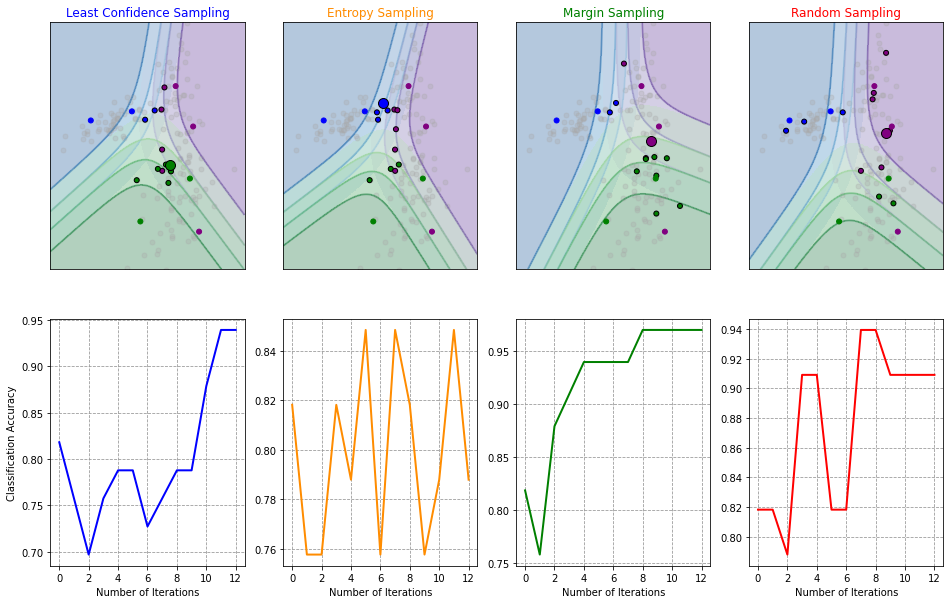

In [7]:
model_LR = LogisticRegression(max_iter=10000)

sampling_dict_class_animate = {
    "Least Confidence Sampling": {
        "model": clone(model_LR),
        "query_strat": uncertainty_sampling,
        "score": [],
        "marker": "o",
        "type": "uncertanity",
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "blue",
        "save_dec": "Least Confidence Decision",
        "save_iter_dc": [11],
        "save_fig": False,
        "X_pool": None,
        "y_pool": None,
    },
    "Entropy Sampling": {
        "model": clone(model_LR),
        "query_strat": entropy_sampling,
        "score": [],
        "marker": "^",
        "type": "uncertanity",
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "darkorange",
        "save_dec": "Entropy Sampling Decision",
        "save_iter_dc": [11],
        "save_fig": False,
        "X_pool": None,
        "y_pool": None,
    },
    "Margin Sampling": {
        "model": clone(model_LR),
        "query_strat": margin_sampling,
        "score": [],
        "marker": "s",
        "type": "uncertanity",
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "green",
        "save_dec": "Margin Sampling Decision",
        "save_iter_dc": [11],
        "save_fig": True,
        "X_pool": None,
        "y_pool": None,
    },
    "Random Sampling": {
        "model": clone(model_LR),
        "query_strat": alu.random_sampling,
        "score": [],
        "mean_score": [],
        "std_dev": [],
        "marker": "H",
        "type": "random",
        "n_iter": 50,
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "red",
        "save_dec": "Random Sampling Decision",
        "save_iter_dc": [0, 11],
        "save_fig": True,
        "X_pool": None,
        "y_pool": None,
    },
}


# All Plots
# plot_list = ["decision_countour", "decision_bound", "accuracy_line"]

plot_list = ["decision_countour", "accuracy_line"]

animate = animate_classification(sampling_dict_class_animate, plot_list, 2, 4, n_queries=12)
HTML(animate.to_jshtml())

<a name="Animation_Uncert_MNIST"></a>